In [4]:
from iexcloud.iexcloud import iexCloud
import pandas as pd
import numpy as np
import nltk
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from prophet import Prophet
from datetime import date
import datetime


nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

file_path = r'all-data.csv'

iex = iexCloud()


/Users/sachinsuri/Desktop/Repos/venv/finviz/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sachinsuri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1]:
df = pd.read_csv(r'all-data.csv', encoding='ISO-8859-1', names=['sentiment', 'sentence'])
df.count()
df.groupby('sentiment').count()

NameError: name 'pd' is not defined

In [1]:

from iexcloud.iexcloud import iexCloud
iex = iexCloud()
iex.get_financial_ratios('AAPL')


,Indicator,2017,2018,2019,2020,2021
0,Current Ratio,1.276,1.124,1.540,1.364,1.075
1,Debt to Assets,0.308,0.313,0.319,0.347,0.355
2,P/E Ratio,16.630,18.791,18.287,33.936,12.958
3,Return on Assets,0.129,0.163,0.163,0.177,0.270
4,Earnings Yield (EPS),0.060,0.053,0.054,0.029,0.076


In [57]:
df = iex.get_max_time_series_df('AAPL')
df['Date'] = pd.to_datetime(df['Date'])
#condition = df['df'] >= date.today()
date_obj = datetime.datetime(2022, 5, 9)
condition = df['Date'] >= date_obj
#df = df[df['Date'] >= date_obj]
df.loc[condition, 'AAPL'] = 1.5 * df.loc[condition, 'AAPL']
df



Fetching time series data for AAPL


,Date,AAPL
0,2017-05-15,38.9250
1,2017-05-16,38.8675
2,2017-05-17,37.5625
3,2017-05-18,38.1350
4,2017-05-19,38.2650
...,...,...
1254,2022-05-09,228.0900
1255,2022-05-10,231.7650
1256,2022-05-11,219.7500
1257,2022-05-12,213.8400


FETCH NEWS ARTICLES FROM IEXCLOUD API

TRAIN SENTIMENT ANALYSIS MODULE

In [38]:
#Function to clean data
def clean_data(df, test):
    #turn all letters to lowercase
    df['sentence'] = df['sentence'].str.lower()

    #normalise text data & remove numbers
    df["sentence"] = df['sentence'].str.replace(
            "(@\[A-Za-z]+)|([^A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?",''
        )

    #Remove stop words
    df['sentence'] = df['sentence'].apply(
            lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])
        )

    df['sentence (format)'] = df['sentence'].str.split(" ")
    df['sentence (stemmed)'] = df['sentence (format)'].apply(lambda x: [stemmer.stem(y) for y in x])
    df = df.drop(['sentence (format)'], axis=1)

    df['sentence stemmed'] = df['sentence'].apply(lambda x: ''.join([str(elem) for elem in x]))
    df = df.drop(['sentence (stemmed)'], axis=1)

    if not test:
        sentiment_score = {
            'neutral': 0,
            'negative': -1,
            'positive': 1
        }

        df['sentiment'] = df['sentiment'].replace(sentiment_score)
        df.columns = df.columns.str.replace(" ", "")
    
        df = df.drop(['sentiment'], axis=1)
        
    return df

In [39]:
df = pd.read_csv(file_path, encoding='ISO-8859-1', names=['sentiment', 'sentence'])
df_train = clean_data(df, True)
df_train

/var/folders/ds/bygxc1vx7y7c1hvcw37ff9kw0000gn/T/ipykernel_86325/2593539304.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df["sentence"] = df['sentence'].str.replace(


,sentiment,sentence,sentence stemmed
0,neutral,according gran company plans move production r...,according gran company plans move production r...
1,neutral,technopolis plans develop stages area less squ...,technopolis plans develop stages area less squ...
2,negative,international electronic industry company elco...,international electronic industry company elco...
3,positive,new production plant company would increase ca...,new production plant company would increase ca...
4,positive,according company updated strategy years baswa...,according company updated strategy years baswa...
...,...,...,...
4841,negative,london marketwatch share prices ended lower lo...,london marketwatch share prices ended lower lo...
4842,neutral,rinkuskiai beer sales fell per cent million li...,rinkuskiai beer sales fell per cent million li...
4843,negative,operating profit fell eur mn eur mn including ...,operating profit fell eur mn eur mn including ...
4844,negative,net sales paper segment decreased eur mn secon...,net sales paper segment decreased eur mn secon...


In [40]:
#Tfidf
tfidf = TfidfVectorizer(max_features = 5000)
x = df['sentence']
y = df['sentiment']

x = tfidf.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    #stratify=y,
    random_state=1,
    test_size =0.2,
    shuffle=True
)

clf = LinearSVC()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.69      0.53      0.60       122
     neutral       0.78      0.87      0.82       570
    positive       0.71      0.60      0.65       278

    accuracy                           0.75       970
   macro avg       0.73      0.67      0.69       970
weighted avg       0.75      0.75      0.74       970



In [42]:
#predictions on test set
ticker_symbol = 'AAPL'
news_df = iex.get_news(ticker_symbol)

x = tfidf.transform(news_df['headline'])
y_pred = clf.predict(x)

y_pred

sentiment_count = {
    0: 0,
    1: 0,
    2: 0
}

for sentiment in y_pred:
    if sentiment == 'neutral':
        sentiment_count[1] += 1
    if sentiment == 'positive':
        sentiment_count[2] += 1
    if sentiment == 'negative':
        sentiment_count[0] += 1 

print(sentiment_count)
weighted_average = (
    (sentiment_count[1] * 1 +
    sentiment_count[2] * 2 +
    sentiment_count[0] * 0) / 100
)
weighted_average


{0: 1, 1: 93, 2: 6}


1.05

TRAIN TIMESERIES FORECASTING MODULE

In [5]:
ticker_symbol = 'AAPL'
ticker_data = iex.get_max_time_series_df(ticker_symbol)
ticker_data = ticker_data.rename(columns = {
    'Date': 'ds',
    ticker_symbol: 'y'
})
ticker_data

Fetching time series data for AAPL


,ds,y
0,2017-05-16,38.8675
1,2017-05-17,37.5625
2,2017-05-18,38.1350
3,2017-05-19,38.2650
4,2017-05-22,38.4975
...,...,...
1253,2022-05-09,152.0600
1254,2022-05-10,154.5100
1255,2022-05-11,146.5000
1256,2022-05-12,142.5600


/Users/sachinsuri/Desktop/Repos/venv/finviz/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.2874
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3615.16    0.00325909       273.681      0.2244      0.2244      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3640.84    0.00579424       96.8407           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3648.67    0.00246782       85.3044           1           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301        3648.8    0.00104921       82.3886   8.227e-06       0.001      421  LS failed, Hessian reset 
     361       3648.98   0.000565485       55.9605   6.073e-06       0.001      556  LS failed, Hessian reset 
     399       3649.03   1.52786e-06       70.6364   0.0008989           1      615   
    Iter      log pro

/Users/sachinsuri/Desktop/Repos/venv/finviz/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/sachinsuri/Desktop/Repos/venv/finviz/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


             ds       trend         cap  yhat_lower  yhat_upper  trend_lower  \
0    2017-05-16   37.834303  184.277812   27.578568   41.588838    37.834303   
1    2017-05-17   37.853650  184.277812   27.272494   41.508406    37.853650   
2    2017-05-18   37.873005  184.277812   27.379094   41.507814    37.873005   
3    2017-05-19   37.892368  184.277812   27.930727   41.504414    37.892368   
4    2017-05-22   37.950499  184.277812   27.178787   41.473433    37.950499   
...         ...         ...         ...         ...         ...          ...   
1353 2022-08-17  171.675465  184.277812  173.271486  186.994199   171.525512   
1354 2022-08-18  171.713960  184.277812  173.703192  187.672838   171.562537   
1355 2022-08-19  171.752346  184.277812  173.618538  187.907840   171.599462   
1356 2022-08-20  171.790623  184.277812  174.554341  188.455889   171.636025   
1357 2022-08-21  171.828792  184.277812  175.253376  188.572003   171.672435   

      trend_upper  multiplicative_terms

/Users/sachinsuri/Desktop/Repos/venv/finviz/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


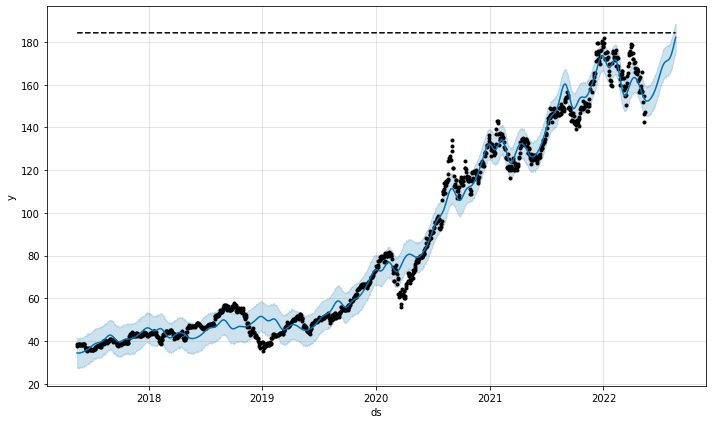

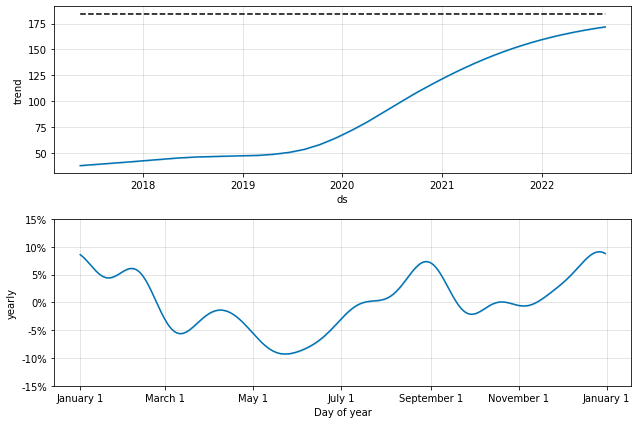

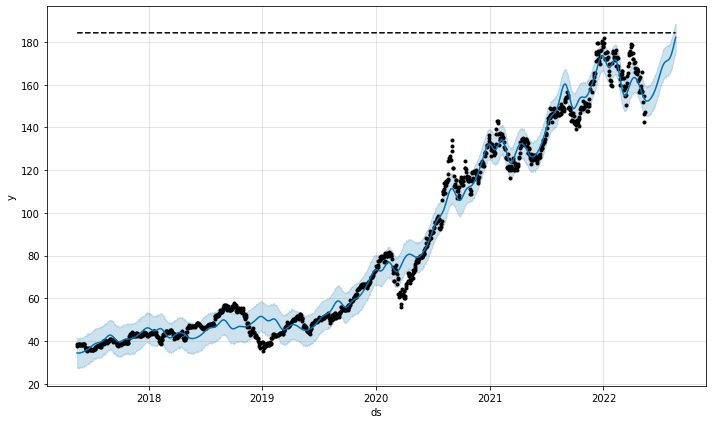

In [8]:
model_params = {
    "daily_seasonality": False,
    "weekly_seasonality": False,
    "yearly_seasonality": True,
    "seasonality_mode": "multiplicative",
    "growth": "logistic"
}


model = Prophet(**model_params)
ticker_data["cap"] = ticker_data['y'].max() + ticker_data['y'].std() * 0.05

model.fit(ticker_data)

future = model.make_future_dataframe(periods=100)
future["cap"] = ticker_data["cap"].max()

forecast = model.predict(future)
print(forecast)
model.plot_components(forecast)
model.plot(forecast)



COMBINE TIMESERIES FORECASTING WITH SENTIMENT ANALYSIS